# Feature Engineering & Selection: Average Daily Population in NYC DOC Custody

### Step 1: Feature Engineering

Using the DV and IVs stored at `../Data/_30_day_adp.csv` and `../Data/_30_day_IVs.csv`, we will create additional independent variables to use in feature selection.

### Step 2: Feature Selection

The methods we use for feature selection are below

**1. Decision Trees & Feature Importance**

First we will fit a decision tree, most likely a random forest regression, on the first 80% of data points for ADP. We will then test the fit on the additional 20% of the data points and look at the important features picked by the decision tree. This will help us deduce which features to include in our final regression. Since multicolinearity is not an issue with decision tree models, we do not need to consider this factor in our first method.

**2. Colinearity and correlational metrics**

However, since we are most likely not using a decision tree regression for our final model we will need to consider multicolinearity as an issue with our regression model. Therefore we will measure the correlation between regressors and between the regressors and the target variable (ADP) to better understand which regressors should and should not be included in our final model.

**3. Regression Performance**

Once we have decided which regressors to include in our model, we will train and test the model on our dataset to measure in and out of sample performance. We will compare the performance for the model trained on all the regressors and just the selected regressors decided after feature engineering to see which model is better suited to our use case.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from functions import *
%matplotlib inline

### Retrieve data

In [2]:
_30day_pop_tot = pd.read_csv("../Data/_30_day_adp.csv", index_col = 0)
#specify data types for start and end date
_30day_pop_tot['Start Date'] = _30day_pop_tot['Start Date'].astype('datetime64[ns]')
_30day_pop_tot['End Date'] = _30day_pop_tot['End Date'].astype('datetime64[ns]')

_30day_pop_tot.head()

,Start Date,End Date,ADP
0,2021-07-02,2021-07-31,5902.0
1,2021-08-01,2021-08-30,5967.0
2,2021-08-31,2021-09-29,5960.0
3,2021-09-30,2021-10-29,5568.0
4,2021-10-30,2021-11-28,5445.0


In [3]:
joined_ivs_df = pd.read_csv("../Data/_30_day_IVs.csv", index_col = 0)
#specify data types for start and end date
joined_ivs_df['Start Date'] = joined_ivs_df['Start Date'].astype('datetime64[ns]')
joined_ivs_df['End Date'] = joined_ivs_df['End Date'].astype('datetime64[ns]')
joined_ivs_df.head()

,Start Date,End Date,admission_count,discharge_count,los_days
0,2021-07-02,2021-07-31,1486,1376,104
1,2021-08-01,2021-08-30,1467,1287,128
2,2021-08-31,2021-09-29,1338,1710,109
3,2021-09-30,2021-10-29,1325,1450,116
4,2021-10-30,2021-11-28,1184,1228,108


# Engineer new variables

We utilized ADP and our exogenous admission, discharge and length of stay data to engineer more independent variables. Below you will find the list of variables we created. 

- **Month:** Month of the 30 day period. If the 30 day period spans multiple months, it is the month of the start date of the period

- **Year:** Year of the 30 day period. If the 30 day period spans multiple years, it is the year of the start date of the period

- **Date_Rank:** Discrete integer [0,n-1] where n is the number of 30-day periods in our data and ranks the periods from earliest to latest by Start Date

- **sqrt_Date_Rank:** The square root of the set of discrete integer [0,n-1] where n is the number of 30-day periods in our data and ranks the periods from earliest to latest by Start Date.

- **Date_Rank^1/3:** The cubed root of the set of discrete integer [0,n-1] where n is the number of 30-day periods in our data and ranks the periods from earliest to latest by Start Date.

- **Holiday:** Binary flag represented whether a major holiday occurs within a 30 day period. We have defined the major holidays to be: New Years, Fourth of July, Labor Day, Halloween, Thanksgiving, Christmas/Hanukkah/Kwanzaa

- **Seasonal Dummy Variables:** Binary indicator for Winter, Spring, Summer, and Fall seasons based on the month variable

- **adp_lag<sub>1</sub>, adp_lag<sub>2</sub>, ..., adp_lag<sub>12</sub>:** Lag terms of ADP up to the 12th previous 30-day period

- **adp_ma<sub>2</sub>, adp_ma<sub>3</sub>, ..., adp_lag<sub>6</sub>:** Moving average of ADP from prior 2 to 6 timeperiods

- **adp_diff<sub>1</sub>:** The difference between current ADP and prior 30-day ADP

- **admit_lag<sub>1</sub>, admit_lag<sub>2</sub>, admit_lag<sub>3</sub>:** Lag terms of adjusted admission count up to the 3rd previous 30-day period


- **dis_lag<sub>1</sub>, dis_lag<sub>2</sub>, dis_lag<sub>3</sub>:** Lag terms of adjusted discharge count up to the 3rd previous 30-day period
                            

In [4]:
#add date related regressors
_30day_pop_tot['Month'] = _30day_pop_tot['Start Date'].dt.month
_30day_pop_tot['Year'] = _30day_pop_tot['Start Date'].dt.year

#make a binary flag for major us holidays: New Years, Fourth of July, Labor Day, Halloween, Thanksgiving, Christmas/Hanukkah/Kwanzaa
_30day_pop_tot['Holiday'] = _30day_pop_tot['Month'].isin([1, 7, 9, 10, 11, 12]).astype(int)
#seasonal dummy variables
_30day_pop_tot['Winter'] = _30day_pop_tot['Month'].isin([1, 2, 12]).astype(int)
_30day_pop_tot['Spring'] = _30day_pop_tot['Month'].isin([3, 4, 5]).astype(int)
_30day_pop_tot['Summer'] = _30day_pop_tot['Month'].isin([6, 7, 8]).astype(int)
_30day_pop_tot['Fall'] = _30day_pop_tot['Month'].isin([9, 10, 11]).astype(int)
_30day_pop_tot['adp_diff1'] = _30day_pop_tot['ADP'].diff(1)
#add lag term
for i in range(1,13):
    _30day_pop_tot['adp_lag'+str(i)] = _30day_pop_tot['ADP'].shift(i)

#fillnas with zero
_30day_pop_tot = _30day_pop_tot.fillna(0)
_30day_pop_tot.head()

,Start Date,End Date,ADP,Month,Year,Holiday,Winter,Spring,Summer,Fall,...,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,2021-07-02,2021-07-31,5902.0,7,2021,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-08-01,2021-08-30,5967.0,8,2021,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-08-31,2021-09-29,5960.0,8,2021,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-30,2021-10-29,5568.0,9,2021,1,0,0,0,1,...,5902.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-10-30,2021-11-28,5445.0,10,2021,1,0,0,0,1,...,5967.0,5902.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Let's also add some moving average terms to our regressors MA(2) - MA(6) may be helpful
for i in range(2,7):
    _30day_pop_tot['adp_ma'+str(i)] = _30day_pop_tot['ADP'].rolling(i, min_periods=i).mean()

#fillnas with zero
_30day_pop_tot = _30day_pop_tot.fillna(0)
_30day_pop_tot.head()

,Start Date,End Date,ADP,Month,Year,Holiday,Winter,Spring,Summer,Fall,...,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12,adp_ma2,adp_ma3,adp_ma4,adp_ma5,adp_ma6
0,2021-07-02,2021-07-31,5902.0,7,2021,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0
1,2021-08-01,2021-08-30,5967.0,8,2021,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,5934.5,0.000000,0.00,0.0,0.0
2,2021-08-31,2021-09-29,5960.0,8,2021,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,5963.5,5943.000000,0.00,0.0,0.0
3,2021-09-30,2021-10-29,5568.0,9,2021,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,5764.0,5831.666667,5849.25,0.0,0.0
4,2021-10-30,2021-11-28,5445.0,10,2021,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,5506.5,5657.666667,5735.00,5768.4,0.0


In [6]:
_30day_pop_tot.tail()

,Start Date,End Date,ADP,Month,Year,Holiday,Winter,Spring,Summer,Fall,...,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12,adp_ma2,adp_ma3,adp_ma4,adp_ma5,adp_ma6
28,2023-10-20,2023-11-18,6163.0,10,2023,1,0,0,0,1,...,5926.0,5947.0,5846.0,5861.0,5910.0,6173.5,6181.333333,6182.00,6171.0,6148.166667
29,2023-11-19,2023-12-18,6132.0,11,2023,1,0,0,0,1,...,5924.0,5926.0,5947.0,5846.0,5861.0,6147.5,6159.666667,6169.00,6172.0,6164.500000
30,2023-12-19,2024-01-17,6038.0,12,2023,1,1,0,0,0,...,6016.0,5924.0,5926.0,5947.0,5846.0,6085.0,6111.000000,6129.25,6142.8,6149.666667
31,2024-01-18,2024-02-16,6181.0,1,2024,1,1,0,0,0,...,6034.0,6016.0,5924.0,5926.0,5947.0,6109.5,6117.000000,6128.50,6139.6,6149.166667
32,2024-02-17,2024-03-17,6250.0,2,2024,0,1,0,0,0,...,6127.0,6034.0,6016.0,5924.0,5926.0,6215.5,6156.333333,6150.25,6152.8,6158.000000


In [7]:
#create lag terms up to i = 3 for admit and discharge data
for i in range(1,4):
    joined_ivs_df['admit_lag'+str(i)] = joined_ivs_df['admission_count'].shift(i)
    joined_ivs_df['dis_lag'+str(i)] = joined_ivs_df['discharge_count'].shift(i)

#fillnas with zero
joined_ivs_df = joined_ivs_df.fillna(0)
joined_ivs_df.head()

,Start Date,End Date,admission_count,discharge_count,los_days,admit_lag1,dis_lag1,admit_lag2,dis_lag2,admit_lag3,dis_lag3
0,2021-07-02,2021-07-31,1486,1376,104,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-08-01,2021-08-30,1467,1287,128,1486.0,1376.0,0.0,0.0,0.0,0.0
2,2021-08-31,2021-09-29,1338,1710,109,1467.0,1287.0,1486.0,1376.0,0.0,0.0
3,2021-09-30,2021-10-29,1325,1450,116,1338.0,1710.0,1467.0,1287.0,1486.0,1376.0
4,2021-10-30,2021-11-28,1184,1228,108,1325.0,1450.0,1338.0,1710.0,1467.0,1287.0


In [8]:
#join DV and IV dataframes
_30day_pop_tot = _30day_pop_tot.merge(joined_ivs_df, how = 'left', left_on = ['Start Date','End Date'], right_on = ['Start Date','End Date'])

#finally lets add a unique id for month-year ranks from earliest to latest date
#in a regression these variables will mimic a linear trend of x, where x is a positive integer (our proxy for time)
_30day_pop_tot['Date_Rank'] = _30day_pop_tot.sort_values(by = ['Year','Month']).index
_30day_pop_tot['ln_Date_Rank'] = np.log(_30day_pop_tot['Date_Rank']).replace(-np.inf,-1000)
_30day_pop_tot['sqrt_Date_Rank'] = np.sqrt(_30day_pop_tot['Date_Rank'])
_30day_pop_tot['Date_Rank^1/3'] = _30day_pop_tot['Date_Rank']**(1/3)

#based on littles law and doc analysis, ADP ~ los * admission counts
#lets create this variable and see if it is significant
_30day_pop_tot['admit_times_los'] = _30day_pop_tot['admission_count']*_30day_pop_tot['los_days']


#create pop change variable
_30day_pop_tot['Adm_Dis_Chng'] = _30day_pop_tot['admission_count'] - _30day_pop_tot['discharge_count']
#create admission and discharge difference 
_30day_pop_tot['admit_diff1'] = _30day_pop_tot['admission_count'].diff(1)
_30day_pop_tot['dis_diff1'] = _30day_pop_tot['discharge_count'].diff(1)
_30day_pop_tot = _30day_pop_tot.fillna(0)
print(len(_30day_pop_tot))
_30day_pop_tot.columns

33


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Index(['Start Date', 'End Date', 'ADP', 'Month', 'Year', 'Holiday', 'Winter',
       'Spring', 'Summer', 'Fall', 'adp_diff1', 'adp_lag1', 'adp_lag2',
       'adp_lag3', 'adp_lag4', 'adp_lag5', 'adp_lag6', 'adp_lag7', 'adp_lag8',
       'adp_lag9', 'adp_lag10', 'adp_lag11', 'adp_lag12', 'adp_ma2', 'adp_ma3',
       'adp_ma4', 'adp_ma5', 'adp_ma6', 'admission_count', 'discharge_count',
       'los_days', 'admit_lag1', 'dis_lag1', 'admit_lag2', 'dis_lag2',
       'admit_lag3', 'dis_lag3', 'Date_Rank', 'ln_Date_Rank', 'sqrt_Date_Rank',
       'Date_Rank^1/3', 'admit_times_los', 'Adm_Dis_Chng', 'admit_diff1',
       'dis_diff1'],
      dtype='object')

In [9]:
_30day_pop_tot.head()

,Start Date,End Date,ADP,Month,Year,Holiday,Winter,Spring,Summer,Fall,...,admit_lag3,dis_lag3,Date_Rank,ln_Date_Rank,sqrt_Date_Rank,Date_Rank^1/3,admit_times_los,Adm_Dis_Chng,admit_diff1,dis_diff1
0,2021-07-02,2021-07-31,5902.0,7,2021,1,0,0,1,0,...,0.0,0.0,0,-1000.000000,0.000000,0.000000,154544,110,0.0,0.0
1,2021-08-01,2021-08-30,5967.0,8,2021,0,0,0,1,0,...,0.0,0.0,1,0.000000,1.000000,1.000000,187776,180,-19.0,-89.0
2,2021-08-31,2021-09-29,5960.0,8,2021,0,0,0,1,0,...,0.0,0.0,2,0.693147,1.414214,1.259921,145842,-372,-129.0,423.0
3,2021-09-30,2021-10-29,5568.0,9,2021,1,0,0,0,1,...,1486.0,1376.0,3,1.098612,1.732051,1.442250,153700,-125,-13.0,-260.0
4,2021-10-30,2021-11-28,5445.0,10,2021,1,0,0,0,1,...,1467.0,1287.0,4,1.386294,2.000000,1.587401,127872,-44,-141.0,-222.0


In [10]:
_30day_pop_tot.tail()

,Start Date,End Date,ADP,Month,Year,Holiday,Winter,Spring,Summer,Fall,...,admit_lag3,dis_lag3,Date_Rank,ln_Date_Rank,sqrt_Date_Rank,Date_Rank^1/3,admit_times_los,Adm_Dis_Chng,admit_diff1,dis_diff1
28,2023-10-20,2023-11-18,6163.0,10,2023,1,0,0,0,1,...,1884.0,1752.0,28,3.332205,5.291503,3.036589,198925,-10,25.0,-1.0
29,2023-11-19,2023-12-18,6132.0,11,2023,1,0,0,0,1,...,1765.0,1834.0,29,3.367296,5.385165,3.072317,163488,-52,-122.0,-80.0
30,2023-12-19,2024-01-17,6038.0,12,2023,1,1,0,0,0,...,1800.0,1836.0,30,3.401197,5.477226,3.107233,159072,84,-46.0,-182.0
31,2024-01-18,2024-02-16,6181.0,1,2024,1,1,0,0,0,...,1825.0,1835.0,31,3.433987,5.567764,3.141381,198084,-30,285.0,399.0
32,2024-02-17,2024-03-17,6250.0,2,2024,0,1,0,0,0,...,1703.0,1755.0,32,3.465736,5.656854,3.174802,178200,28,-142.0,-200.0


### Feature Selection
#### Decision Trees & Feature Importance

First we will fit a decision tree, most likely a random forest regression, on the first 80% of data points for ADP. We will then test the fit on the additional 20% of the data points and look at the important features picked by the decision tree. This will help us deduce which features to include in our final regression. Since multicolinearity is not an issue with decision tree models, we do not need to consider this factor in our first method.

In [11]:
#define X and y data
y = _30day_pop_tot['ADP']
X = _30day_pop_tot.drop(columns = ['Start Date','End Date','ADP'])

#80-20 split
# Split the dataset into features (X) and target (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 123)
    
print('The size of the training set is:', len(X_train))
print('The size of the test set is:', len(X_test))

The size of the training set is: 26
The size of the test set is: 7


In [12]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Instantiate the RandomForestRegressor
rfr = RandomForestRegressor(random_state=0)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

Best parameters found:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [13]:
# Get the best model
best_rfr = grid_search.best_estimator_
# Predict the Test set results using the best model
y_pred = best_rfr.predict(X_test)

IS_pred = best_rfr.predict(X_train)
print('IS R2 with best model : {0:0.4f}'.format(r2_score(y_train, IS_pred)))
print('OS R2 with best model : {0:0.4f}'.format(r2_score(y_test, y_pred)))
print('IS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_train, IS_pred)))
print('OS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_test, y_pred)))


IS R2 with best model : 0.9670
OS R2 with best model : 0.9281
IS MAE with best model : 31.2954
OS MAE with best model : 63.1543


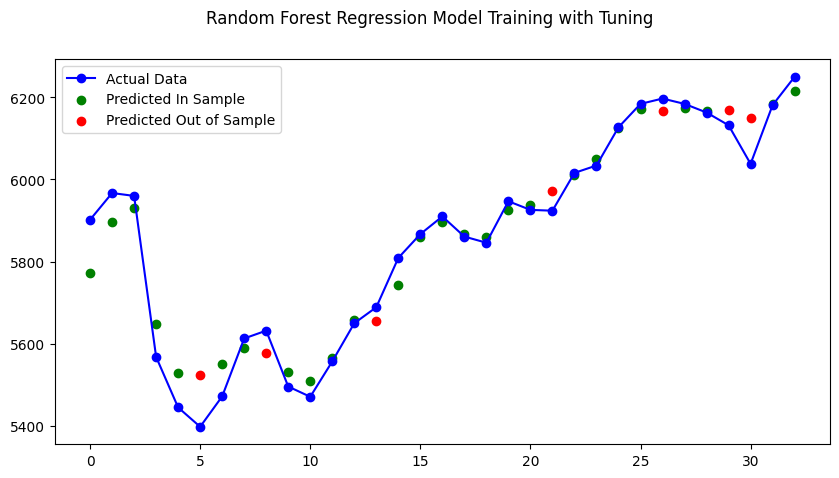

In [14]:
#plot the actual data and the predictions
fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Random Forest Regression Model Training with Tuning')

actual, = plt.plot(y.index,y, 'bo-', label='Actual Data')
predicted_IS = plt.scatter(y_train.index, IS_pred, color='green', label='Predicted In Sample')
predicted_OS = plt.scatter(y_test.index, y_pred, color='red', label='Predicted Out of Sample')

plt.legend(handles=[actual,predicted_IS,predicted_OS])
plt.show()



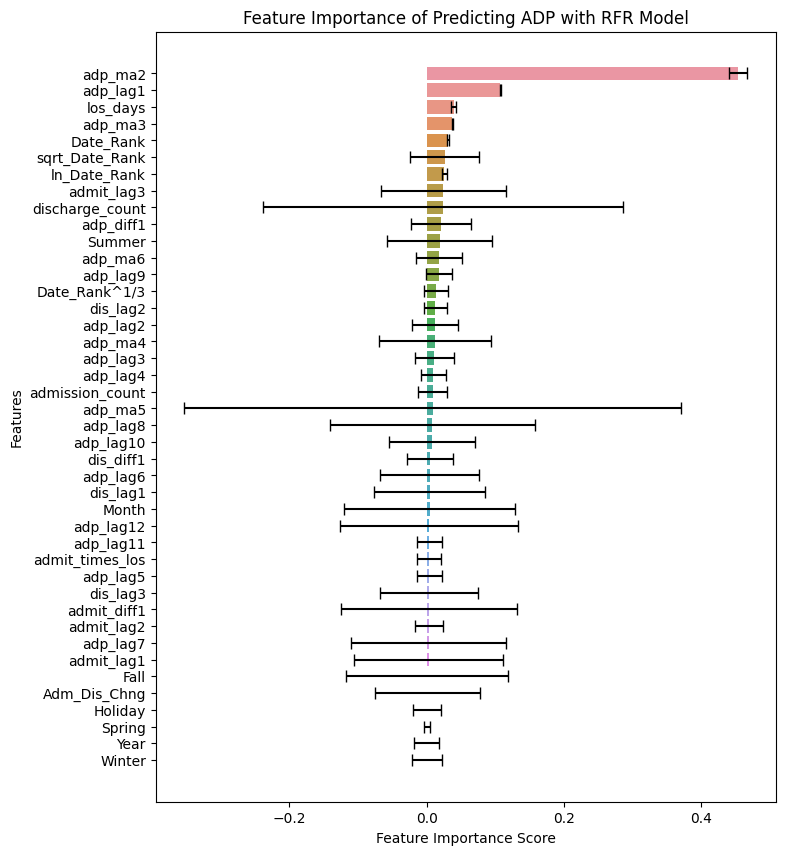

In [15]:
#print the avg feature importance across all the trees
feature_scores = pd.Series(best_rfr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in best_rfr.estimators_], axis=0)
#plot features
# Create the bar plot with error bars (std)
fig = plt.figure(figsize=(8,10))
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.errorbar(x=feature_scores, y=feature_scores.index, xerr=std, fmt='none', color='black', capsize=4)

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance of Predicting ADP with RFR Model')
# Visualize the graph
plt.show()

Based on the output above, it seems like the most important features are:

* the moving average of the prior 2 & 3 data points (adp_ma2, adp_ma3)

* the prior data point (adp_lag1)

* length of stay (los_days)

* Date_Rank and sqrt_Date_Rank

Let's predict ADP with just the top 5 & 10 features and see how the in sample and out of sample metrics compare.

IS R2 with best model : 0.9907
OS R2 with best model : 0.2834
IS MAE with best model : 18.7542
OS MAE with best model : 153.2543


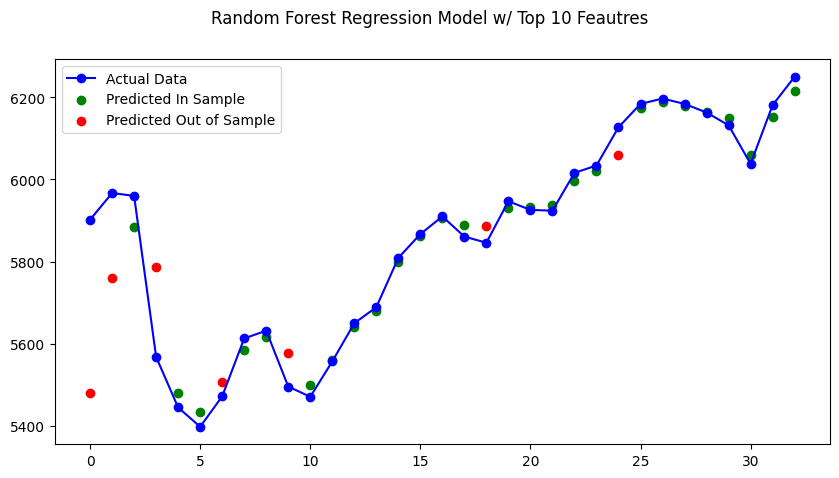

In [16]:
#lets train model just on top 10 features
top10_feature_scores = feature_scores[:10]
top10_features = top10_feature_scores.index.to_list()
#redefine X to only include top 10 features
X = _30day_pop_tot[top10_features]
#80-20 split with different random state (give us a different 80-20 split as initial rfr above)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 456)

#fit model
# Instantiate the RandomForestRegressor
rfr = RandomForestRegressor(random_state=0).fit(X_train, y_train)

# Predict the Test set results using the best model
y_pred = rfr.predict(X_test)

IS_pred = rfr.predict(X_train)
print('IS R2 with best model : {0:0.4f}'.format(r2_score(y_train, IS_pred)))
print('OS R2 with best model : {0:0.4f}'.format(r2_score(y_test, y_pred)))
print('IS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_train, IS_pred)))
print('OS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_test, y_pred)))

#plot the actual data and the predictions
fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Random Forest Regression Model w/ Top 10 Feautres')

actual, = plt.plot(y.index,y, 'bo-', label='Actual Data')
predicted_IS = plt.scatter(y_train.index, IS_pred, color='green', label='Predicted In Sample')
predicted_OS = plt.scatter(y_test.index, y_pred, color='red', label='Predicted Out of Sample')
plt.legend(handles=[actual,predicted_IS,predicted_OS])
plt.show()

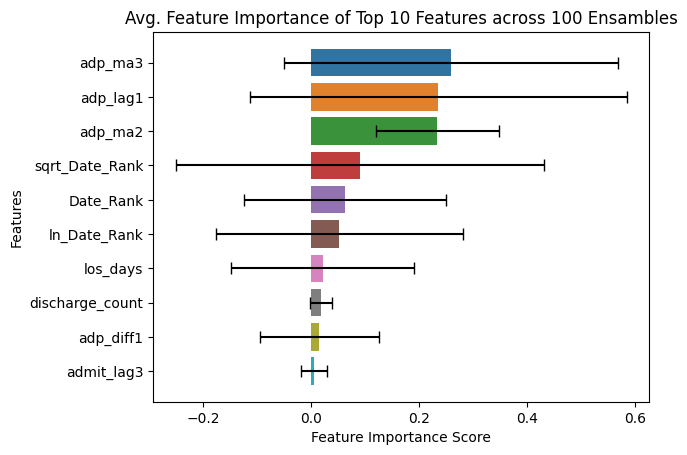

In [17]:
#print the avg feature importance across all the trees
feature_scores = pd.Series(rfr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)
#plot features
# Create the bar plot with error bars (std)
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.errorbar(x=feature_scores, y=feature_scores.index, xerr=std, fmt='none', color='black', capsize=4)

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Avg. Feature Importance of Top 10 Features across 100 Ensambles')
# Visualize the graph
plt.show()

IS R2 with best model : 0.9907
OS R2 with best model : 0.1761
IS MAE with best model : 19.6331
OS MAE with best model : 163.0386


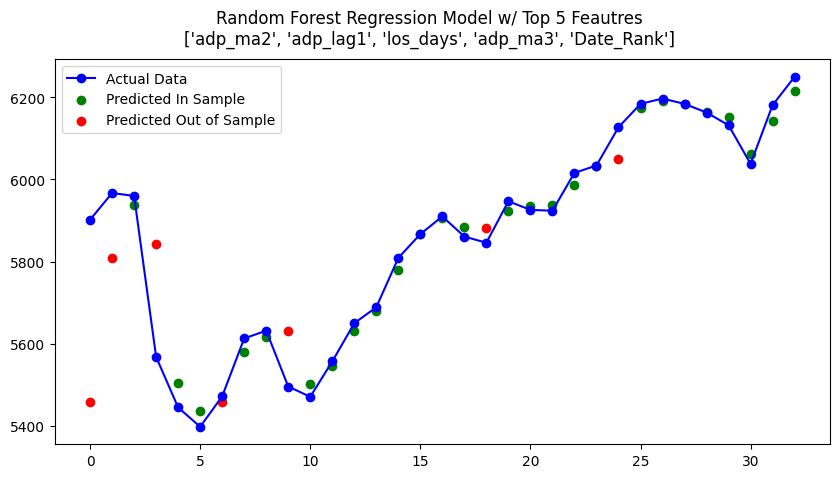

In [18]:
#lets just do top 5 features and only chose one of the date rank variables
top5_features = top10_features[:5]
X = _30day_pop_tot[top5_features]
#80-20 split with different random state (give us a different 80-20 split as initial rfr above)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 456)

#fit model
# Instantiate the RandomForestRegressor
rfr = RandomForestRegressor(random_state=0).fit(X_train, y_train)

# Predict the Test set results using the best model
y_pred = rfr.predict(X_test)

IS_pred = rfr.predict(X_train)
print('IS R2 with best model : {0:0.4f}'.format(r2_score(y_train, IS_pred)))
print('OS R2 with best model : {0:0.4f}'.format(r2_score(y_test, y_pred)))
print('IS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_train, IS_pred)))
print('OS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_test, y_pred)))

#plot the actual data and the predictions
fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Random Forest Regression Model w/ Top 5 Feautres\n{top5_features}')

actual, = plt.plot(y.index,y, 'bo-', label='Actual Data')
predicted_IS = plt.scatter(y_train.index, IS_pred, color='green', label='Predicted In Sample')
predicted_OS = plt.scatter(y_test.index, y_pred, color='red', label='Predicted Out of Sample')
plt.legend(handles=[actual,predicted_IS,predicted_OS])
plt.show()

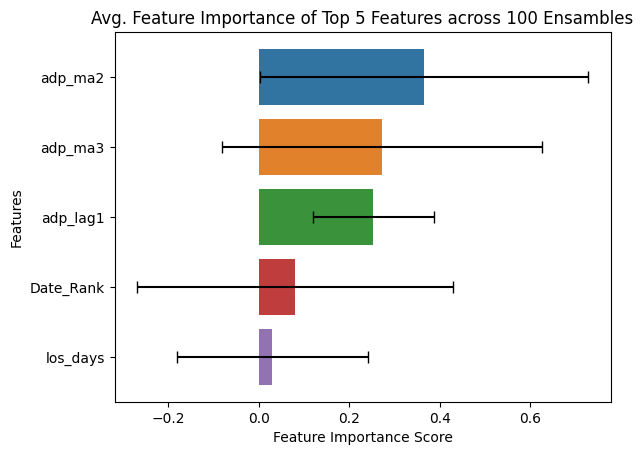

In [19]:
#print the avg feature importance across all the trees
feature_scores = pd.Series(rfr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)
#plot features
# Create the bar plot with error bars (std)
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.errorbar(x=feature_scores, y=feature_scores.index, xerr=std, fmt='none', color='black', capsize=4)

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Avg. Feature Importance of Top 5 Features across 100 Ensambles')
# Visualize the graph
plt.show()

IS R2 with best model : 0.9910
OS R2 with best model : 0.1809
IS MAE with best model : 19.0742
OS MAE with best model : 160.2086


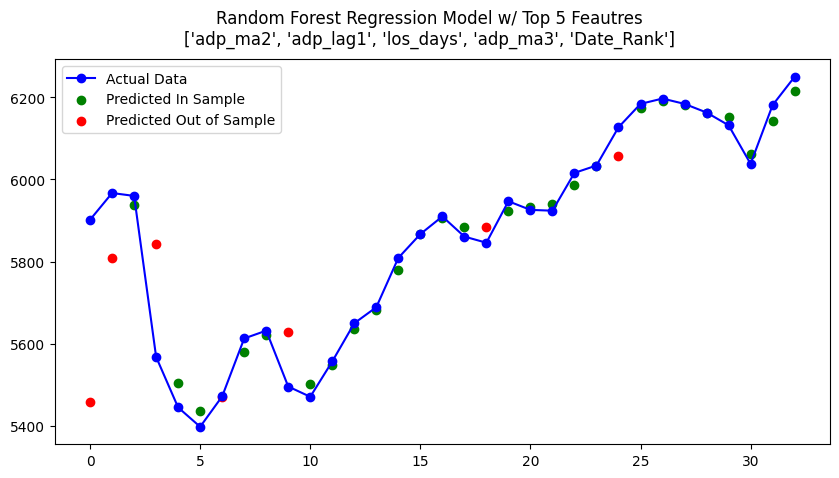

In [20]:
#use sqrt_date_rank instead of date_rank
top5_features_2 = ['adp_ma2', 'adp_lag1', 'los_days', 'adp_ma3', 'sqrt_Date_Rank']
X = _30day_pop_tot[top5_features_2]
#80-20 split with different random state (give us a different 80-20 split as initial rfr above)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 456)

#fit model
# Instantiate the RandomForestRegressor
rfr = RandomForestRegressor(random_state=0).fit(X_train, y_train)

# Predict the Test set results using the best model
y_pred = rfr.predict(X_test)

IS_pred = rfr.predict(X_train)
print('IS R2 with best model : {0:0.4f}'.format(r2_score(y_train, IS_pred)))
print('OS R2 with best model : {0:0.4f}'.format(r2_score(y_test, y_pred)))
print('IS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_train, IS_pred)))
print('OS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_test, y_pred)))

#plot the actual data and the predictions
fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Random Forest Regression Model w/ Top 5 Feautres\n{top5_features}')

actual, = plt.plot(y.index,y, 'bo-', label='Actual Data')
predicted_IS = plt.scatter(y_train.index, IS_pred, color='green', label='Predicted In Sample')
predicted_OS = plt.scatter(y_test.index, y_pred, color='red', label='Predicted Out of Sample')
plt.legend(handles=[actual,predicted_IS,predicted_OS])
plt.show()

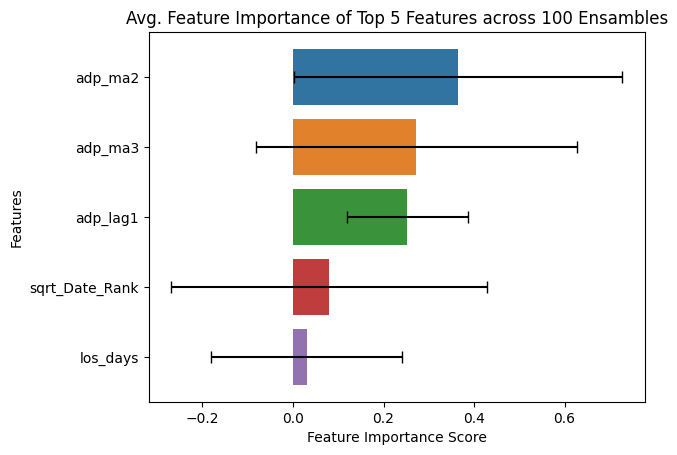

In [21]:
#print the avg feature importance across all the trees
feature_scores = pd.Series(rfr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)
#plot features
# Create the bar plot with error bars (std)
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.errorbar(x=feature_scores, y=feature_scores.index, xerr=std, fmt='none', color='black', capsize=4)

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Avg. Feature Importance of Top 5 Features across 100 Ensambles')
# Visualize the graph
plt.show()

IS R2 with best model : 0.9605
OS R2 with best model : 0.8262
IS MAE with best model : 32.6438
OS MAE with best model : 65.0229


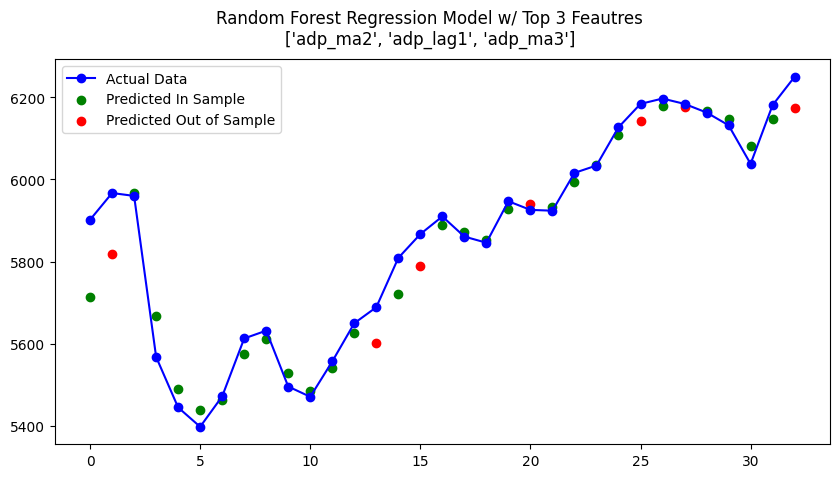

In [22]:
#use sqrt_date_rank instead of date_rank
top3_features = ['adp_ma2', 'adp_lag1', 'adp_ma3']
X = _30day_pop_tot[top3_features]
#80-20 split with different random state (give us a different 80-20 split as initial rfr above)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 678)

#fit model
# Instantiate the RandomForestRegressor
rfr = RandomForestRegressor(random_state=0).fit(X_train, y_train)

# Predict the Test set results using the best model
y_pred = rfr.predict(X_test)

IS_pred = rfr.predict(X_train)
print('IS R2 with best model : {0:0.4f}'.format(r2_score(y_train, IS_pred)))
print('OS R2 with best model : {0:0.4f}'.format(r2_score(y_test, y_pred)))
print('IS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_train, IS_pred)))
print('OS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_test, y_pred)))

#plot the actual data and the predictions
fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Random Forest Regression Model w/ Top 3 Feautres\n{top3_features}')

actual, = plt.plot(y.index,y, 'bo-', label='Actual Data')
predicted_IS = plt.scatter(y_train.index, IS_pred, color='green', label='Predicted In Sample')
predicted_OS = plt.scatter(y_test.index, y_pred, color='red', label='Predicted Out of Sample')
plt.legend(handles=[actual,predicted_IS,predicted_OS])
plt.show()

### Colinearity and correlational metrics

However, since we are most likely not using a decision tree regression for our final model we will need to consider multicolinearity as an issue with our regression model. Therefore we will measure the correlation between regressors and between the regressors and the target variable (ADP) to better understand which regressors should and should not be included in our final model.

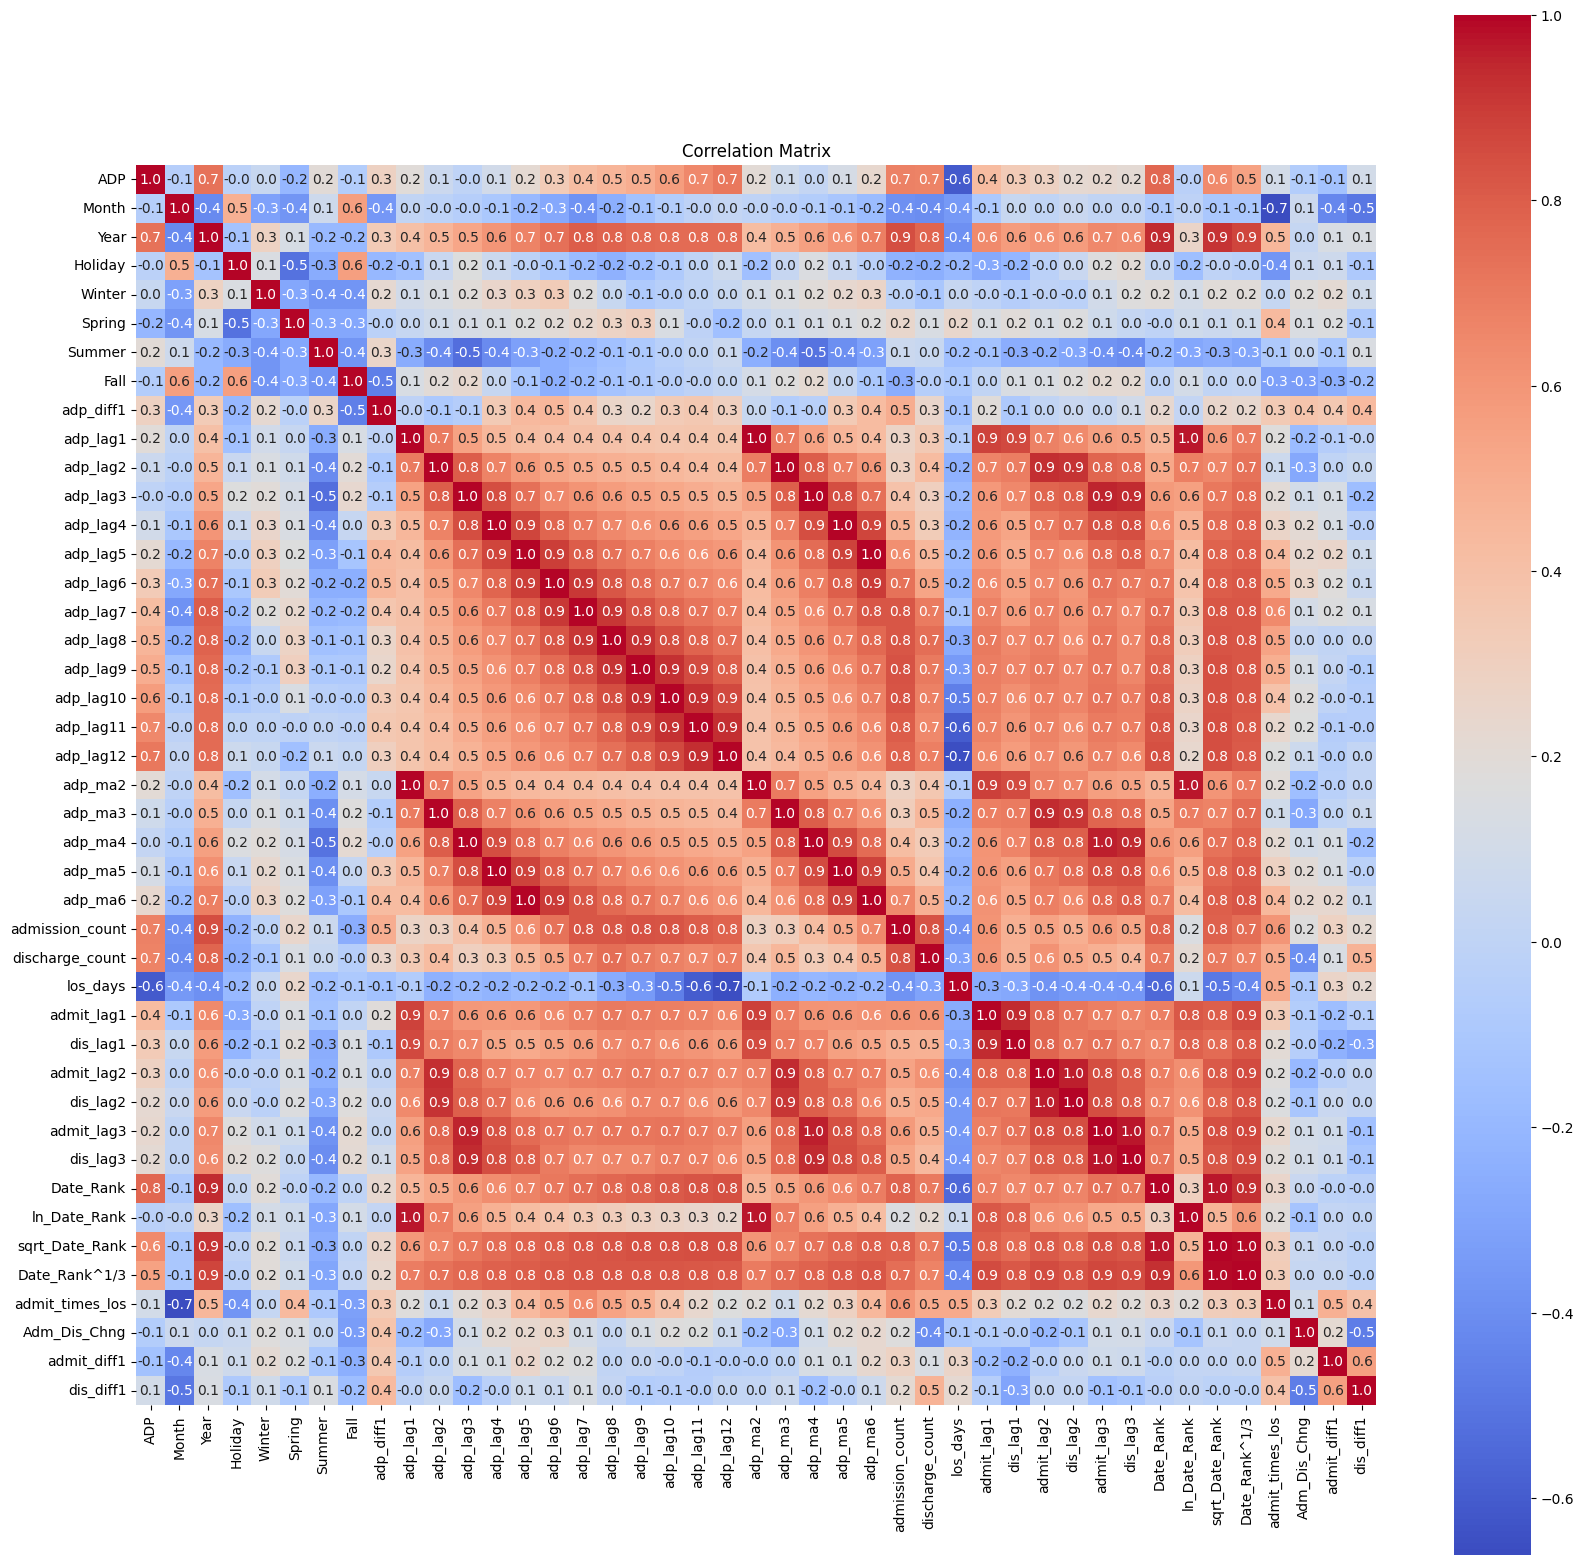

In [23]:
# Selecting only numerical columns
numerical_columns = _30day_pop_tot.select_dtypes(include=['float64', 'int64','int32'])

# Calculating correlation matrix
correlation_matrix = numerical_columns.corr()

# Plotting correlation matrix using seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt="0.1f", square=True)
plt.title('Correlation Matrix')
plt.show()

According to Pressbooks chapter on [testing the significant of the correlation coefficient](https://pressbooks-dev.oer.hawaii.edu/introductorystatistics/chapter/testing-the-significance-of-the-correlation-coefficient/#:~:text=Compare%20r%20to%20the%20appropriate,use%20the%20line%20for%20prediction.), the reliability of the linear model also depends on how many observed data points are in the sample. We need to look at both the value of the correlation coefficient r and the sample size n, together. The [95% Critical Values of the Sample Correlation Coefficient Table](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/table-of-critical-values-pearson-correlation/) can be used to give you a good idea of whether the coefficient value is significant or not. Compare the coefficient to the appropriate critical value in the table. If the coefficeint is not between the positive and negative critical values, then the correlation coefficient is significant. If it is significant, then you may want to use the line for prediction.

Since we have 33 data points ($n$), the degrees of freedom for a two-tailed test is $n-2=31$. At a significance level of $\alpha = 0.05$, our critical values are $\pm 0.349$. Thus anything falling outside of that range is deemed statistically significant and can be used in our regression.

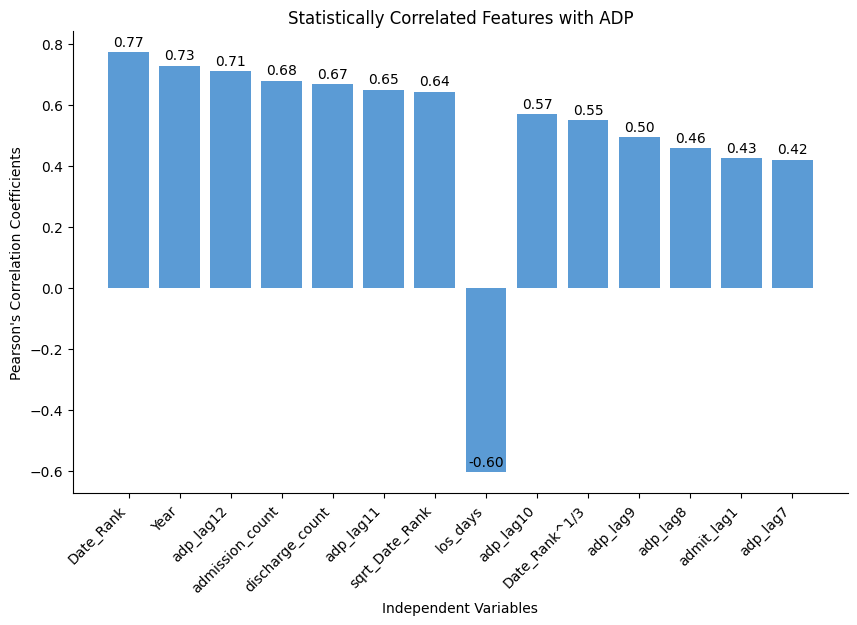

In [24]:
# Replace it with your actual correlation coefficients
correlation_coefficients = correlation_matrix['ADP'].iloc[1:]

# Extract the statistically sig
top_coefficients = correlation_coefficients[correlation_coefficients.abs().values >= 0.349].sort_values(ascending = False, key = abs)


# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(top_coefficients.index, top_coefficients, color=(91/255, 155/255, 213/255))

plt.xlabel('Independent Variables')
plt.ylabel("Pearson's Correlation Coefficients")
plt.title('Statistically Correlated Features with ADP')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add text to each bar
for bar, coeff in zip(bars, top_coefficients):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{coeff:.2f}', 
             ha='center', va='bottom', color='black')
plt.savefig('../Outputs/stat_sig_corr_ivs.png', bbox_inches = 'tight')
plt.show()

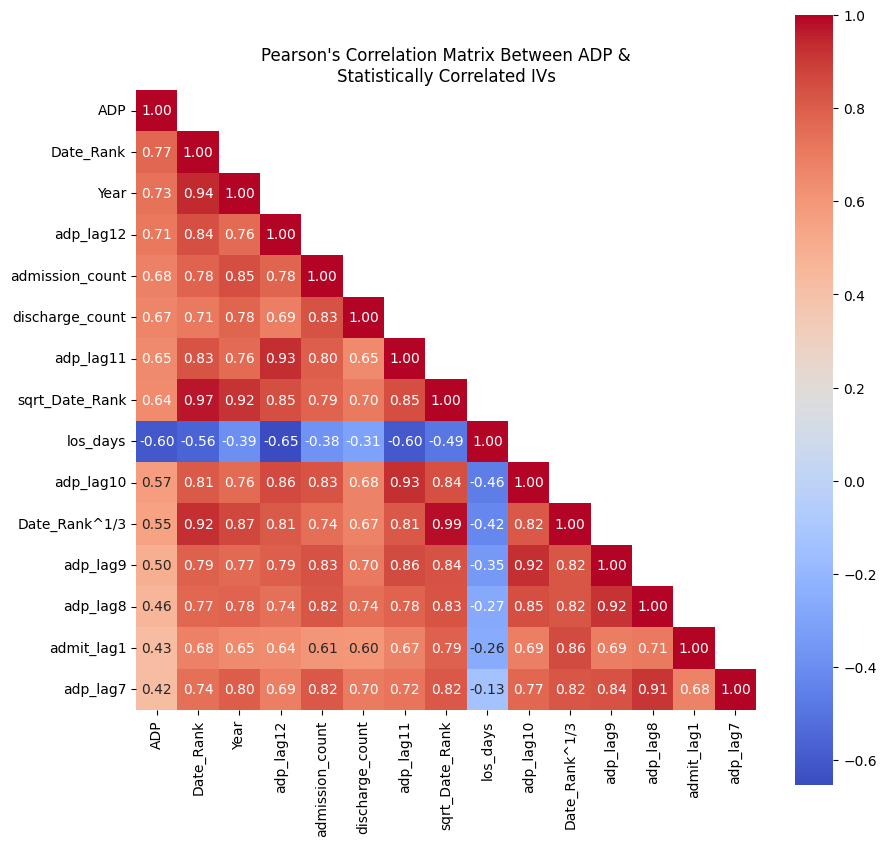

In [25]:
#print correlation matrix between the top 10 features
top_indices = top_coefficients.index
top_columns = _30day_pop_tot[['ADP']+top_indices.to_list()]

# Calculating correlation matrix
correlation_matrix = top_columns.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plotting correlation matrix using seaborn with masked upper triangle
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt="0.2f", square=True, mask=mask)
plt.title("Pearson's Correlation Matrix Between ADP &\nStatistically Correlated IVs")
plt.savefig('../Outputs/multicoll_ivs.png', bbox_inches = 'tight')
plt.show()

- Date_Rank, Year, sqrt_Date_Rank and Date_Rank^1/3 are all statistically correlated with our target variable ADP. We must chose one for the final regression to represent the relationship between ADP and time. I am inclined to use sqrt_Date_Rank, as opposed to Date_Rank or Year, despite its reduced correlation coefficient because we know that ADP will not and cannot increase linearly in time. In other words, we know there is a capacity limit to the population on Rikers and felony crimes will not continue to increase unboundlessly in time therefore we will chose a regressor that is bounded.

- Admission and discharge counts are highly correlated with ADP and are also correlated with one another, we should avoid using the two in a model together.

- Similarly, adp_lag11 and adp_lag12 are too correlated with one another. We will use adp_lag12 because given the monthly granularity of our data it makes most sense to use the ADP 12 months prior to predict current ADP.

It is interested that neither adp_ma2 or adp_lag1 are among the top IVs by correlation coefficient. This may indicate a non-linear relationship between the IV and DV that is being picked up in the random forest model.

### Regression Performance

Once we have decided which regressors to include in our model, we will train and test the model on our dataset to measure in and out of sample performance. We will compare the performance for the model trained on all the regressors and just the selected regressors decided after feature engineering to see which model is better suited to our use case.

3468.217510207184 48.91007219931715
12781.17114228146 93.61909858725345
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     35.86
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           3.72e-09
Time:                        16:14:02   Log-Likelihood:                 32.577
No. Observations:                  26   AIC:                            -47.15
Df Residuals:                      17   BIC:                            -35.83
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

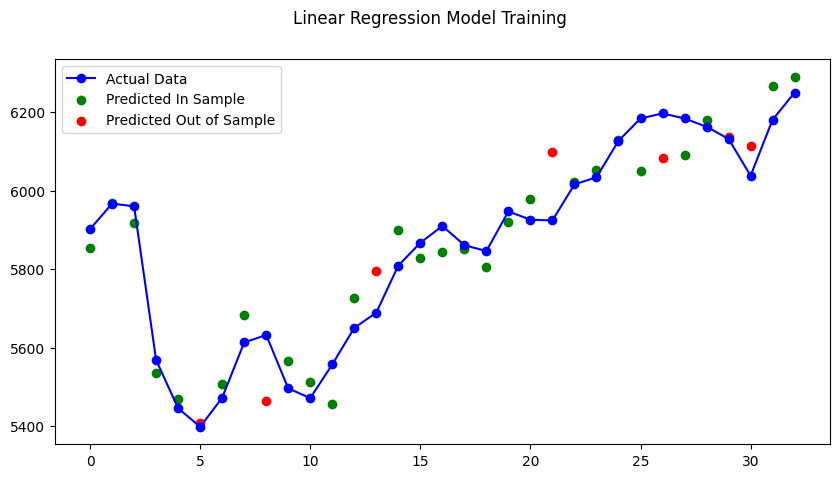

In [26]:
#linear regression with all regressors
regressor_ls = ['Date_Rank','admission_count','discharge_count','adp_lag8','adp_lag12', 'dis_lag1', 'dis_lag2','dis_lag3']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

14462.785790903235 97.11264597382117
22888.680106030486 131.73601667807492
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     13.15
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           9.47e-06
Time:                        16:14:02   Log-Likelihood:                 14.014
No. Observations:                  26   AIC:                            -16.03
Df Residuals:                      20   BIC:                            -8.478
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

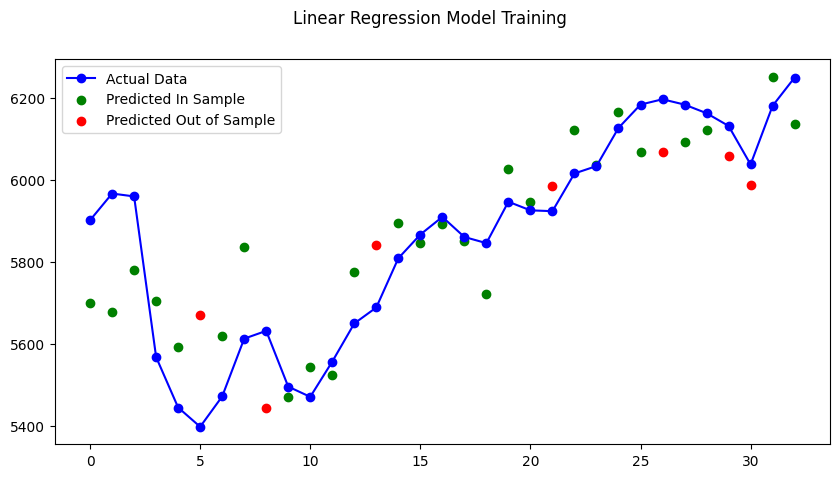

In [27]:
#see how the above model compares without Year variables
regressor_ls = ['Date_Rank','admission_count','discharge_count','adp_lag8','adp_lag12']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

4286.569382714647 54.75324137129043
13277.126085295333 107.23777656999717
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     53.85
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           6.42e-11
Time:                        16:14:02   Log-Likelihood:                 29.823
No. Observations:                  26   AIC:                            -47.65
Df Residuals:                      20   BIC:                            -40.10
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

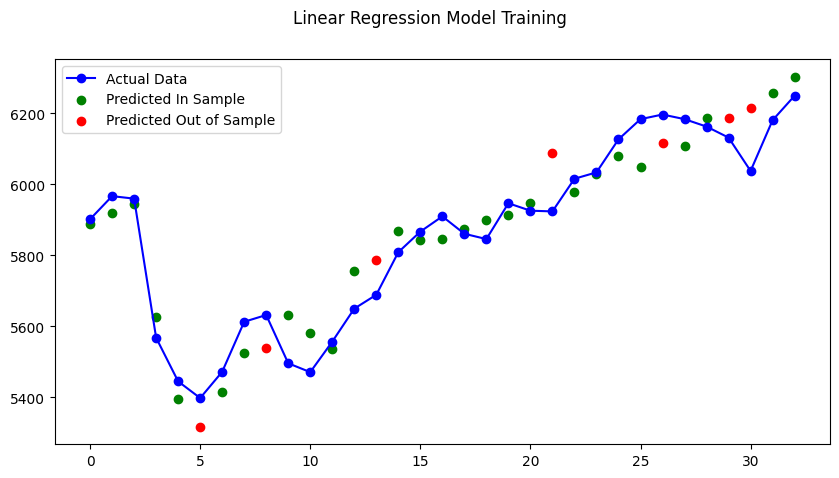

In [28]:
#see how the above model compares without Year variables
regressor_ls = ['Date_Rank','admission_count', 'dis_lag3','adp_lag4','adp_lag12']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

8087.263774496192 68.0877755344517
7516.2148791354775 71.51037128393376
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     35.00
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           5.22e-09
Time:                        16:14:02   Log-Likelihood:                 21.570
No. Observations:                  26   AIC:                            -33.14
Df Residuals:                      21   BIC:                            -26.85
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

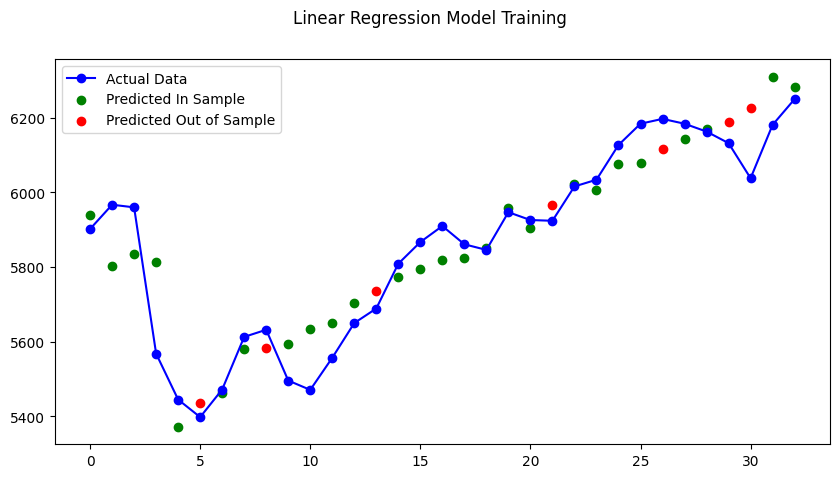

In [29]:
#see how the above model compares without adp_lag12 variable since its the only one above that isnt statistically sig a  = 0.05
regressor_ls = ['Date_Rank','admission_count', 'dis_lag1','adp_lag4']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

6682.74416048764 63.89678929970712
13219.15875438953 105.34261487029367
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     60.70
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           8.38e-11
Time:                        16:14:03   Log-Likelihood:                 24.050
No. Observations:                  26   AIC:                            -40.10
Df Residuals:                      22   BIC:                            -35.07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

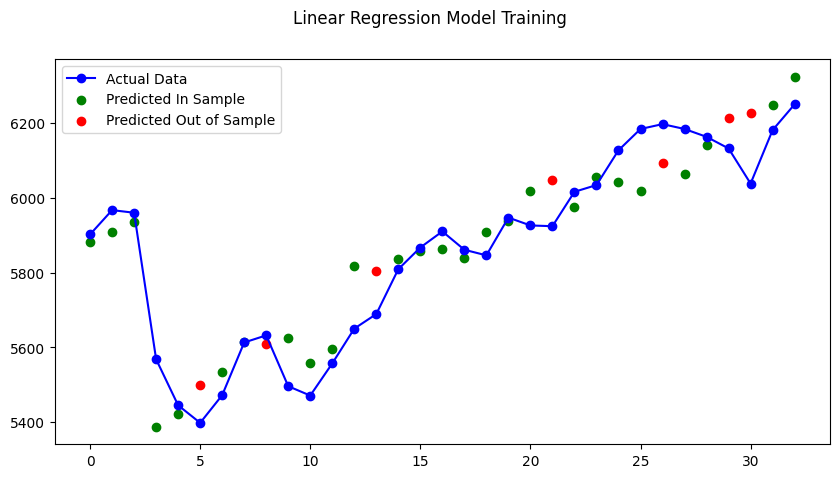

In [30]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['Date_Rank','adp_lag12','admit_lag3']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

7062.103649038002 71.17952281706798
16813.380482683086 105.04361628439281
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     57.05
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           1.53e-10
Time:                        16:14:03   Log-Likelihood:                 23.332
No. Observations:                  26   AIC:                            -38.66
Df Residuals:                      22   BIC:                            -33.63
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

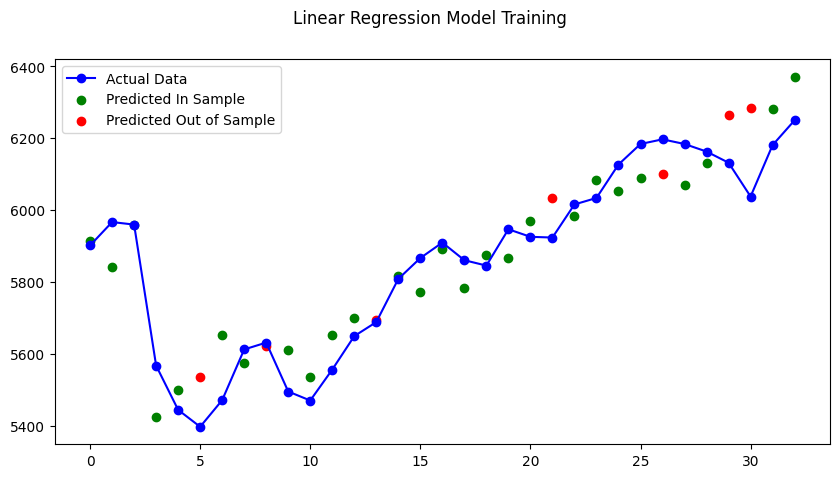

In [31]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['Date_Rank','los_days','admit_lag3']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

12722.97670285937 84.55639252106906
16668.980441934116 104.6202053677923
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     28.40
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           9.47e-08
Time:                        16:14:03   Log-Likelihood:                 15.680
No. Observations:                  26   AIC:                            -23.36
Df Residuals:                      22   BIC:                            -18.33
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

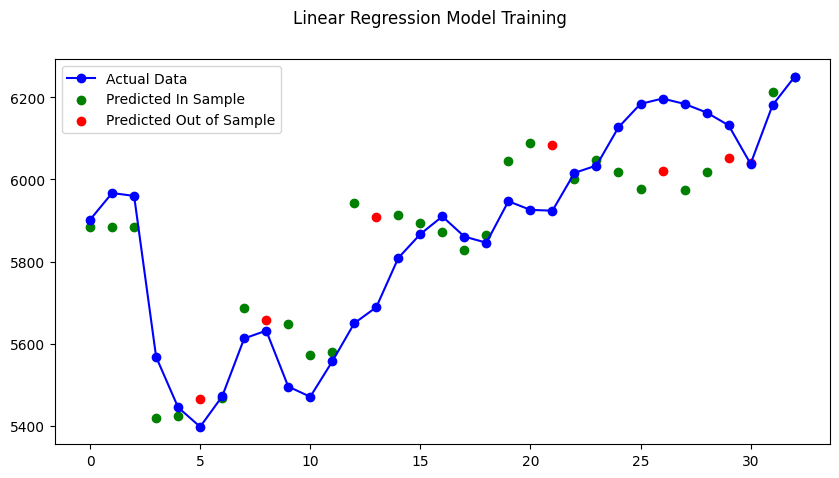

In [32]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['Year','admit_lag3','adp_lag12']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

21316.57332073337 123.60957887973834
26839.225101062097 146.15739077086332
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     14.00
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           2.54e-05
Time:                        16:14:03   Log-Likelihood:                 8.9707
No. Observations:                  26   AIC:                            -9.941
Df Residuals:                      22   BIC:                            -4.909
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

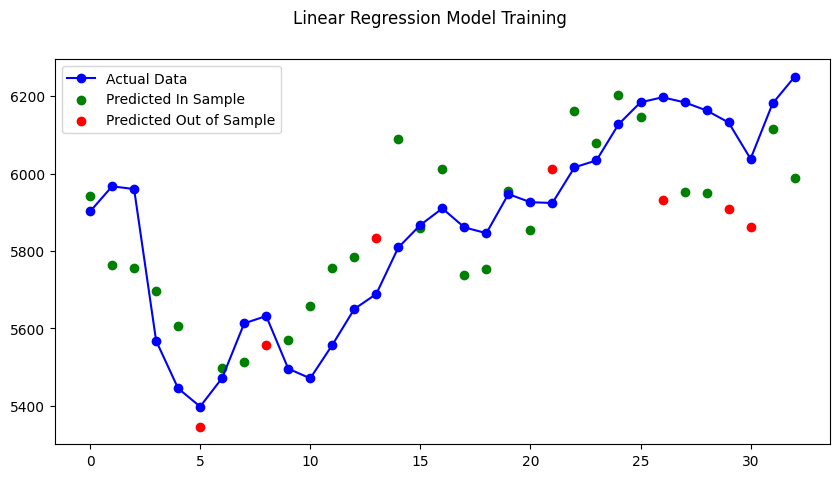

In [33]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['admission_count','los_days','adp_ma6']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

28000.317520416414 138.14252609988827
27667.356473371194 149.9742927203515
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     8.904
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           0.000472
Time:                        16:14:03   Log-Likelihood:                 5.4252
No. Observations:                  26   AIC:                            -2.850
Df Residuals:                      22   BIC:                             2.182
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

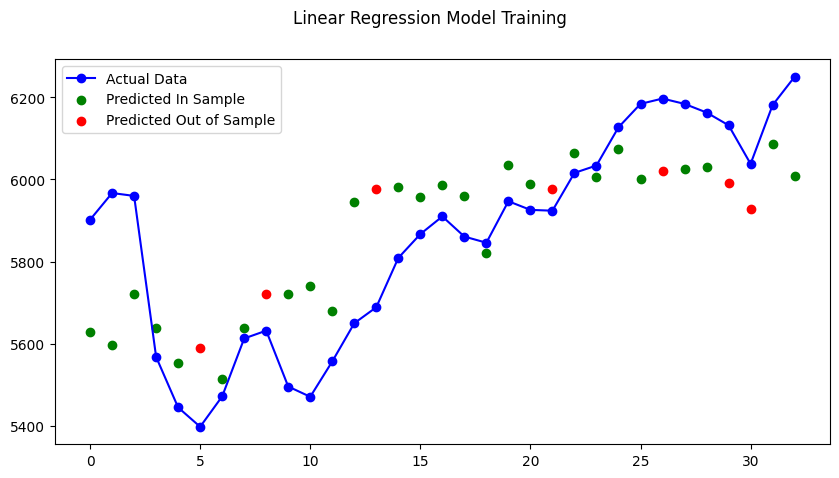

In [34]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['admission_count','discharge_count','adp_lag12']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

11874.37722285777 93.83881092860967
15154.630753244606 109.96943468299352
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     30.96
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           4.47e-08
Time:                        16:14:03   Log-Likelihood:                 16.577
No. Observations:                  26   AIC:                            -25.15
Df Residuals:                      22   BIC:                            -20.12
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

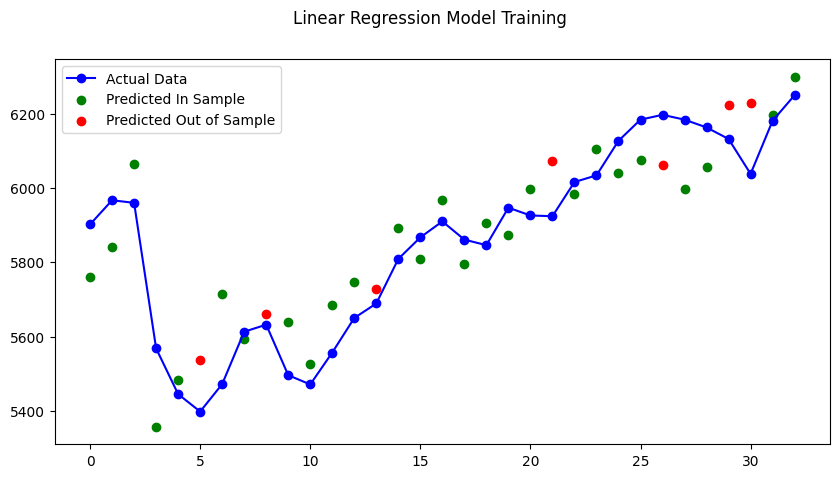

In [35]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['sqrt_Date_Rank','los_days','admit_lag3']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

16190.04708131773 91.03745763588708
6926.887323997996 69.93983872951569
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     20.75
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           1.30e-06
Time:                        16:14:04   Log-Likelihood:                 12.547
No. Observations:                  26   AIC:                            -17.09
Df Residuals:                      22   BIC:                            -12.06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

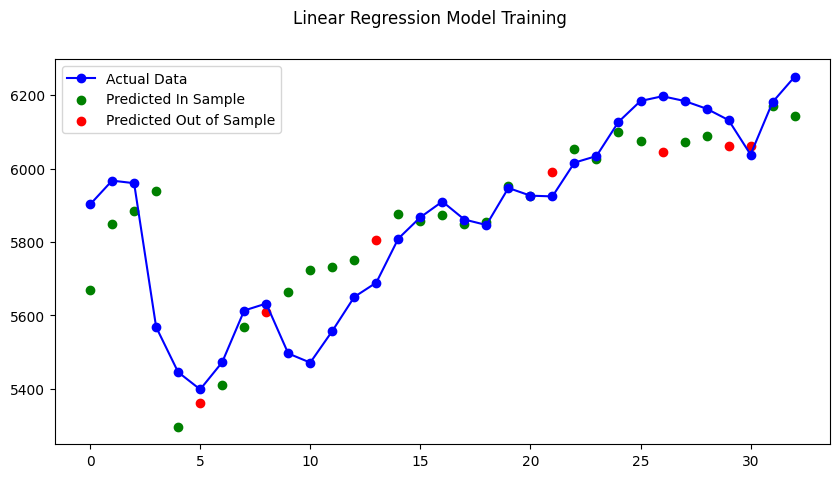

In [36]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['sqrt_Date_Rank','adp_lag4','admission_count']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

22136.50446643302 114.67449323826885
17025.729139960877 109.48985686508864
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     13.21
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           3.81e-05
Time:                        16:14:04   Log-Likelihood:                 8.4801
No. Observations:                  26   AIC:                            -8.960
Df Residuals:                      22   BIC:                            -3.928
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

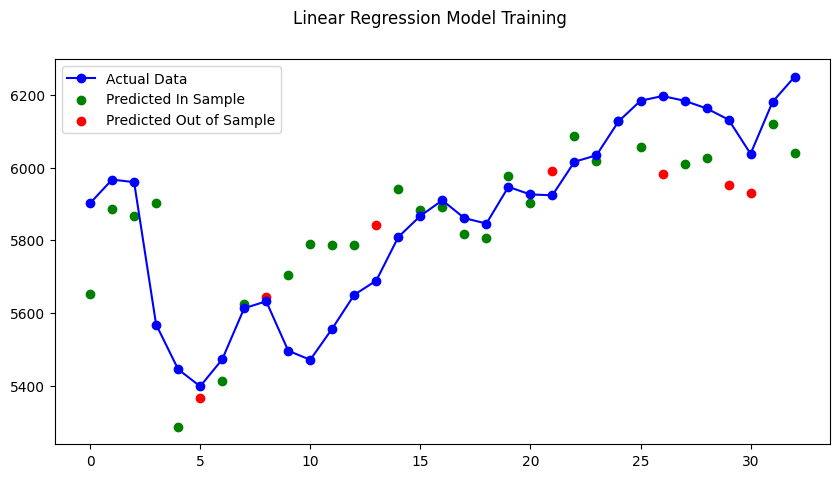

In [37]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['Date_Rank^1/3','adp_lag4','admission_count']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

16190.04708131773 91.03745763588708
6926.887323997996 69.93983872951569
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     20.75
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           1.30e-06
Time:                        16:16:44   Log-Likelihood:                 12.547
No. Observations:                  26   AIC:                            -17.09
Df Residuals:                      22   BIC:                            -12.06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

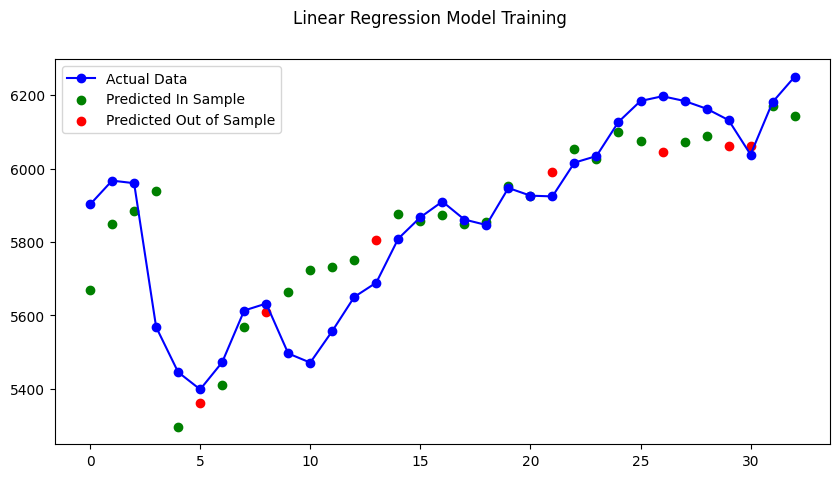

In [44]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['sqrt_Date_Rank','adp_lag4','admission_count']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

10584.4255758489 80.09160404407916
8274.785044856913 74.38923130209436
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     35.62
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           1.28e-08
Time:                        16:15:02   Log-Likelihood:                 18.072
No. Observations:                  26   AIC:                            -28.14
Df Residuals:                      22   BIC:                            -23.11
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

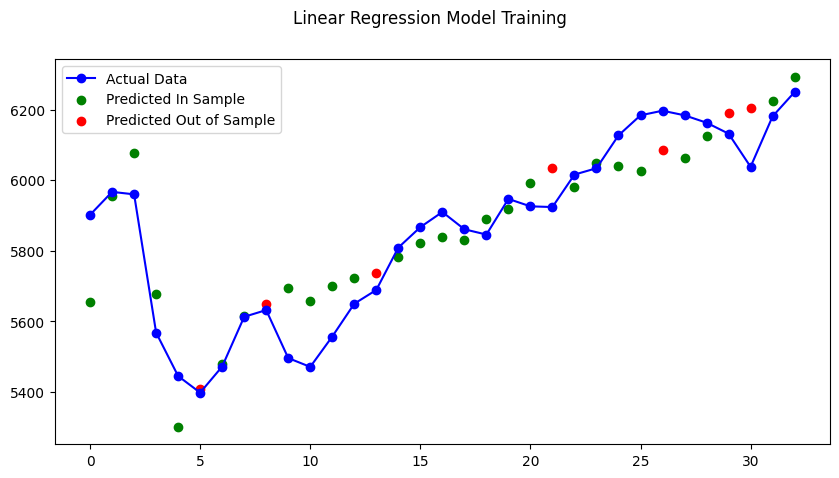

In [40]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['sqrt_Date_Rank','adp_lag4','admit_lag3']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

These results are promising. Below find the model performance results by input regressor:


| Regressors | $R^2$ | In Sample MAE | Out of Sample MAE|Significance $\alpha$ = 0.05|
|------------|-------|---------------|------------------|------------|
|['Year','admission_count', 'dis_lag1','adp_lag4','adp_lag12'] | 0.810 | 75.82 | 190.5 |No|
|['Date_Rank','admission_count', 'dis_lag1','adp_lag4','adp_lag12'] | 0.888 | 58.80 | 83.02 |No|
|['Date_Rank','admission_count', 'dis_lag1','adp_lag4'] | 0.872 | 59.77 | 98.85 |Yes|
|['Date_Rank','adp_lag4','admission_count']|0.802|70.38|63.58|Yes|
|['sqrt_Date_Rank','adp_lag4','admit_lag3']|0.759|86.49|85.86|Yes|
|['sqrt_Date_Rank','adp_lag4','admission_count']|0.690|93.97|178.8|No|

Considerations:

- small sample size: Due to the small sample sizes during model fit, it is difficult to definitely deduce statistically significant relationships between DV and IVs. We should limit the number of regressors and therefore pick the models with a maximum of three IVs.

- Based on the results above, the regression with input variables ['Date_Rank','admission_count', 'dis_lag1','adp_lag4','adp_lag12'] has the rightest r-square value. This is probably due to overfitting (which you can see based on the increased out of sample error) and therefore we will not pick this model. 

- Based on the results above, the regression with input variables ['Date_Rank','admission_count', 'adp_lag4'] has the lowest out of sample average absolute error. I am willing to compromise for the decreased in sample performance as compared to the other models as it ensures we are not overfitting to our training data. However, since we do not know the admission count for the next 12 timestamps, we will also need to predict this in order to predict ADP using the regression model.

- I also lean towards using the model with input variables of ['sqrt_Date_Rank','adp_lag4','admit_lag3'] despite the r-square and out of sample MAE not being optimal because I know that the relationship between time and ADP is not fully linear. There is an absolute maximum number of individuals that can be in DOC custody therefore using a non-linear variable makes the most sense as we increase the size of our data sample. This method also forces us to have to predict admission counts into the future but since we will be using the third time lag of admission rates, the first three data points of our prediction will be more accurate than the model mentioned in the above bullet since these are observable values as opposed to predictions.